# *Credit Card Fraud Detection - Task 2 & Task 3*

![logo](images/logo.jpg)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

warnings.filterwarnings('ignore')

data = pd.read_csv("data/data.csv")

def contextualize(title, xlabel, ylabel):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

## Modelação Preditiva

### Seleção de Técnicas de Modelação

Tomando em consideração os objetivos de mineração de dados, em particular o problema de classificação a tratar, optam-se pelas seguintes técnicas de modelação:
1. ***K-Nearest Neighbors*** - classifica novos dados através da sua proximidade com os dados já existentes, de acordo com as classes dos *k* vizinhos mais próximos
2. ***Naive Bayes*** - baseia-se no Teorema de Bayes e no conceito de probabilidade condicionada para efetuar a classificação
3. ***Decision Tree*** - toma decisões a partir dos atributos de cada cliente, dividindo sucessivamente o conjunto inicial em subconjuntos de menor dimensão
4. ***Bagging*** - obtém um conjunto de modelos usando diferentes amostras do conjunto de treino
5. ***Random Forest*** - combina as previsões de várias árvores de decisão
6. ***AdaBoost*** - cria uma sequência de classificadores simples e ajusta iterativamente o peso de cada instância mal classificada
7. ***Gradient Boosting*** - cria uma sequência de classificadores simples em que cada um tenta corrigir os erros do anterior
8. ***Support Vector Machine*** - procura o hiper-plano que melhor separa os registos das diferentes classes, maximizando a margem
9. ***Artificial Neural Network*** - aprende padrões complexos nos dados através de camadas de "neurónios" artificiais
10. ***Voting*** - combina as previsões de vários modelos diferentes

O número elevado de diferentes técnicas a experimentar prende-se com o facto de, desconhecendo-se a estrutura/organização subjacente aos dados, procurar-se o modelo que melhor se adapta aos mesmos e que produz os melhores resultados.

### Geração do *Design* do Teste

Todos os modelos devem ser treinados com um conjunto de dados de treino e testados num conjunto de dados de teste. Assim, é necessário dividir o conjunto de dados nestes dois subconjuntos, de forma aleatória.

In [2]:
predictors = data.drop('is_fraud', axis = 1)

targets = data['is_fraud']

(train_predictors, test_predictors, train_targets, test_targets) = train_test_split(predictors, targets, test_size = 0.25, random_state = 10, shuffle = True, stratify = targets)

A variável `predictors` contém as variáveis preditivas e os respetivos valores, enquanto a variável `targets` contém os valores correspondentes da variável-alvo.

A função `train_test_split` separa os dados em conjuntos de treino e de teste, de modo que o conjunto de teste contenha 25% dos dados originais e de forma estratificada de acordo com a variável-alvo, isto é, para que a proporção de registos de cada classe (transações fraudulentas e legítimas) seja igual no conjunto de treino e no conjunto de teste.

Para cada técnica de modelação, o processo será o seguinte:
1. Tendo em conta que o conjunto de dados é desequilibrado, recorrer-se-á à técnica de *Synthetic Minority Over-Sampling* (SMOTE), que cria novos exemplos sintéticos da classe minoritária (transações fraudulentas), reduzindo os riscos de seguir abordagens desinformadas de *undersampling* e de *oversampling* - este processo será apenas aplicado nos dados de treino, para evitar fugas de informação para os dados de teste;
2. A par disso, para uniformizar as amplitudes das escalas dos diferentes atributos numéricos e evitar que os atributos de maior magnitude absorvam/dominem os atributos de menor magnitude, far-se-á *Min-Max Scaling*, por já ter sido determinado previamente que as variáveis de interesse não seguem nem estão próximas de uma distribuição normal;
3. Finalmente, para melhorar os resultados obtidos no processo de afinação de hiper-parâmetros de cada modelo e para evitar flutuações dos resultados de avaliação devidos à divisão aleatória dos dados em conjuntos de treino e de teste, recorrer-se-á a *cross-validation*. Assim, dividir-se-ão os dados em *k* subconjuntos e usar-se-á um dos subconjuntos como conjunto de teste e os restantes conjuntos como conjunto de treino, repetindo este processo *k* vezes, mas garantindo que cada subconjunto só é considerado conjunto de teste uma única vez. Neste caso, realiza-se *stratified cross-validation*, de modo que a proporção da variável-alvo se mantenha constante em cada um dos subconjuntos gerados. O valor de *k* variará entre 5 e 10, dependendo da técnica de modelação em causa, para tentar equilibrar os benefícios de efetuar *cross-validation* com uma computação em tempo útil.

Note-se que, para técnicas de modelação mais demoradas e dispendiosas computacionalmente, utilizar-se-á apenas uma fração do conjunto de dados de treino.

In [3]:
def hyperparameter_tuning(pipeline, parameter_grid, name, k, fraction = 1):
    if fraction == 1:
        sampled_train_predictors = train_predictors
        sampled_train_targets = train_targets
    else:
        np.random.seed(10)
        sample_indexes = np.random.choice(len(train_predictors), round(len(train_predictors) * fraction), False)
        sampled_train_predictors = np.array(train_predictors)[sample_indexes]
        sampled_train_targets = np.array(train_targets)[sample_indexes]

    pipeline.fit(sampled_train_predictors, sampled_train_targets)
    probabilities = pipeline.predict_proba(test_predictors)[:, 1]
    auc = roc_auc_score(test_targets, probabilities)
    print(name, '- AUC Pré-Afinação: {:.2f}'.format(auc))

    cross_validation = StratifiedKFold(n_splits = k, shuffle = True, random_state = 10)
    model = GridSearchCV(pipeline, parameter_grid, cv = cross_validation, n_jobs = -1, scoring = 'roc_auc')

    model.fit(sampled_train_predictors, sampled_train_targets)
    auc = model.score(test_predictors, test_targets)
    
    print(name, '(Grid Search) - Melhores Parâmetros:', model.best_params_)
    print(name, '(Grid Search) - AUC Pós-Afinação: {:.2f}'.format(auc))

    return model, auc

O critério primordial de avaliação dos modelos será a área abaixo da curva *Receiver Operating Characteristic* (ROC) - *Area Under Curve* (AUC) -  entre a probabilidade prevista e o valor real da variável-avo. Assim, avaliar-se-á cada modelo quanto à sua capacidade de distinguir corretamente transações fraudulentas de legítimas.

In [4]:
def plot_roc_curve(model, name):
    probabilities = model.predict_proba(test_predictors)[:, 1]
    fpr, tpr, thresholds = roc_curve(test_targets, probabilities)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize = (5, 5))
    plt.plot(fpr, tpr, label = f'Curva ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Classificador Aleatório')
    contextualize(name + ' - Curva ROC', 'Rácio de Falsos Positivos (FPR)', 'Rácio de Verdadeiros Positivos (TPR)')
    plt.legend(loc = 'lower right')
    plt.show()


Para além disso, serão calculadas as restantes métricas de avaliação (exatidão, precisão e *recall*), bem como visualizada a matriz de confusão, tendo em vista uma comparação completa e adequadamente fundamentada dos modelos.

In [5]:
def plot_confusion_matrix(model, name):
    predictions = model.predict(test_predictors)
    print(classification_report(test_targets, predictions))

    ConfusionMatrixDisplay(confusion_matrix(test_targets, predictions)).plot()
    contextualize(name + ' - Matriz de Confusão', 'Classe Prevista', 'Classe Real')
    plt.show()

Nos modelos aplicáveis, será ainda visualizada a *feature importance* obtida, isto é, a importância de cada atributo no processo de classificação.

In [6]:
def plot_feature_importance(model, name):
    plt.figure(figsize = (5, 5))
    plt.barh(train_predictors.columns, model.best_estimator_['classifier'].feature_importances_)
    contextualize(name + ' - Feature Importance', 'Importância', 'Atributo')
    plt.show()

### Construção dos Modelos

#### *K-Nearest Neighbors*

In [7]:
knn_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state = 10)),
    ('classifier', KNeighborsClassifier(n_jobs = -1))
])

knn_parameter_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['manhattan', 'euclidean', 'chebyshev']
}

knn_name = 'K-Nearest Neighbors'

knn, knn_auc = hyperparameter_tuning(knn_pipeline, knn_parameter_grid, knn_name, 10)

K-Nearest Neighbors - AUC Pré-Afinação: 0.52
K-Nearest Neighbors (Grid Search) - Melhores Parâmetros: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 7, 'classifier__weights': 'uniform'}
K-Nearest Neighbors (Grid Search) - AUC Pós-Afinação: 0.52


O algoritmo *K-Nearest Neighbors* - independentemente da afinação de hiper-parâmetros - obtém uma AUC de 0.52 a classificar os dados de teste. O algoritmo executa em cerca de 30 segundos.

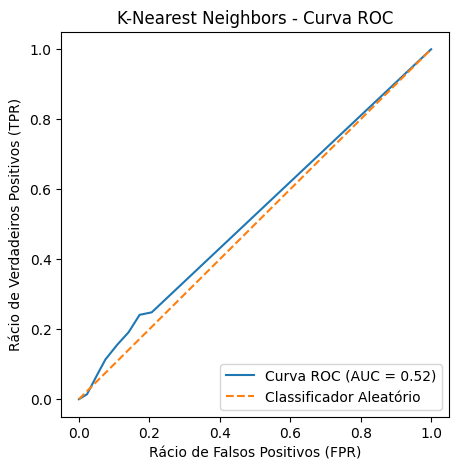

In [8]:
plot_roc_curve(knn, knn_name)

Visualmente, evidencia-se que este desempenho do *K-Nearest Neighbors* nos dados de teste é ligeiramente melhor do que um classificador aleatório, em termos de AUC.

              precision    recall  f1-score   support

           0       0.98      0.89      0.93      7202
           1       0.03      0.16      0.05       141

    accuracy                           0.88      7343
   macro avg       0.50      0.52      0.49      7343
weighted avg       0.96      0.88      0.92      7343



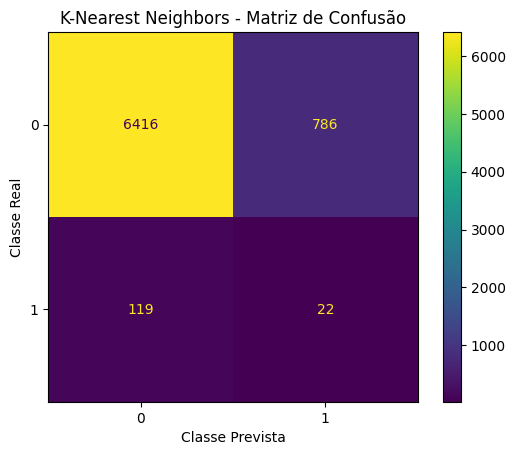

In [9]:
plot_confusion_matrix(knn, knn_name)

Observando a matriz de confusão, percebe-se que este modelo só classificou corretamente 22 transações como fraudulentas, tendo uma forte tendência para classificar como fraudulentas transações que não o são (786). Por isso, o algoritmo *K-Nearest Neighbors* obtém (para a classe positiva) valores de precisão de 3% e *recall* de 16%, sendo estes resultados consideravelmente baixos. O valor obtido para a exatidão (88%) não tem relevância, dado que o conjunto de dados é extremamente desequilibrado, com uma prevalência muito maior de transações legítimas, pelo que um modelo que classificasse todas as transações como legítimas teria uma exatidão de 98%, sendo, no entanto, desprovido de qualquer relevância ou interesse prático.

#### *Naive Bayes*

In [10]:
naive_bayes_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state = 10)),
    ('classifier', GaussianNB())
])

naive_bayes_parameter_grid = {
    'classifier__var_smoothing': [1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

naive_bayes_name = 'Naive Bayes'

naive_bayes, naive_bayes_auc = hyperparameter_tuning(naive_bayes_pipeline, naive_bayes_parameter_grid, naive_bayes_name, 10)

Naive Bayes - AUC Pré-Afinação: 0.56
Naive Bayes (Grid Search) - Melhores Parâmetros: {'classifier__var_smoothing': 1e-06}
Naive Bayes (Grid Search) - AUC Pós-Afinação: 0.56


O algoritmo *Naive Bayes* - antes e depois da afinação de hiper-parâmetros - obtém a mesma AUC (0.56), executando em menos de 5 segundos.

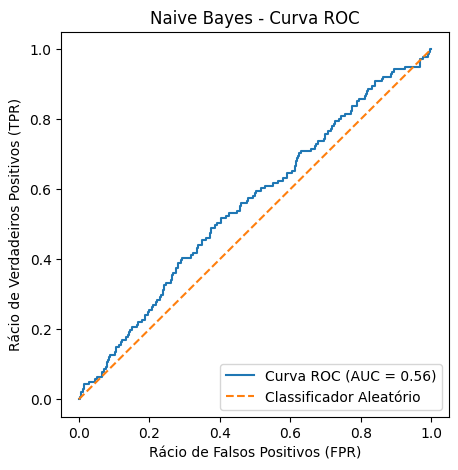

In [11]:
plot_roc_curve(naive_bayes, naive_bayes_name)

Ao comparar o classificador *Naive Bayes* com um classificador aleatório, verifica-se que o primeiro é melhor do que o segundo quanto à AUC.

              precision    recall  f1-score   support

           0       0.99      0.27      0.42      7202
           1       0.02      0.79      0.04       141

    accuracy                           0.28      7343
   macro avg       0.50      0.53      0.23      7343
weighted avg       0.97      0.28      0.42      7343



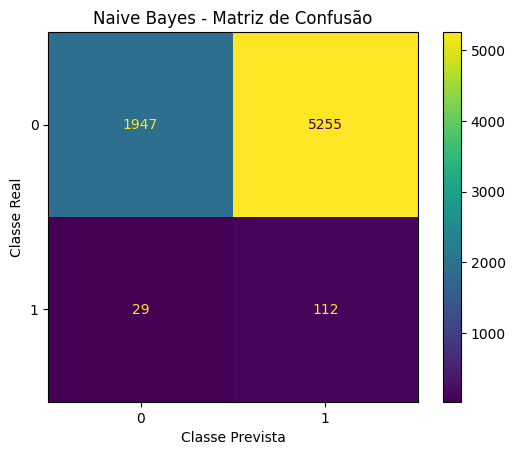

In [12]:
plot_confusion_matrix(naive_bayes, naive_bayes_name)

Ao observar a matriz de confusão, evidencia-se que a maior parte das transações legítimas foram classificadas pelo algoritmo *Naive Bayes* como fraudulentas, o que não é desejável. Efetivamente, isto resulta numa precisão (para a classe positiva) de 2%, ou seja, o modelo tem uma forte tendência para classificar como fraudulentas transações que são legítimas. Este resultado é extremamente baixo e, a par disso, o valor obtido para a exatidão (28%) também não é satisfatório. No entanto, o resultado de *recall* (79%) é elevado, dado que o modelo conseguiu capturar corretamente a maior parte das transações fraudulentas (112), apesar de ter identificado incorretamente muitas transações legítimas como fraudulentas.

#### *Decision Tree*

In [13]:
decision_tree_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', DecisionTreeClassifier(random_state = 10, class_weight = 'balanced'))
])

decision_tree_parameter_grid = {
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__splitter': ['best', 'random'],
    'classifier__max_depth': [None, 5, 10, 15, 20],
    'classifier__max_features': [None, 'sqrt', 'log2'],
}

decision_tree_name = 'Decision Tree'

decision_tree, decision_tree_auc = hyperparameter_tuning(decision_tree_pipeline, decision_tree_parameter_grid, decision_tree_name, 10)

Decision Tree - AUC Pré-Afinação: 0.51
Decision Tree (Grid Search) - Melhores Parâmetros: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': None, 'classifier__splitter': 'best'}
Decision Tree (Grid Search) - AUC Pós-Afinação: 0.57


A *Decision Tree* - antes da afinação de hiper-parâmetros - obtém uma AUC de 0.51. Contudo, depois da afinação de hiper-parâmetros, a AUC nos dados de teste sobe significativamente para 0.57. Isto explica-se porque este algoritmo é extremamente instável e sensível a hiper-parâmetros, pelo que pequenas modificações podem resultar num muito melhor desempenho. Esta técnica de modelação executa em cerca de 10 segundos.

Note-se que, para esta técnica de modelação em particular, não foi utilizado SMOTE, dado que o próprio algoritmo da *Decision Tree* admite um atributo `class_weight` com valor `balanced`, que utiliza os valores da variável-alvo *is_fraud* para ajustar automaticamente os pesos de forma inversamente proporcional às frequências das classes nos dados de *input*. A definição deste atributo resultou num desempenho superior, em comparação com a utilização de SMOTE. 

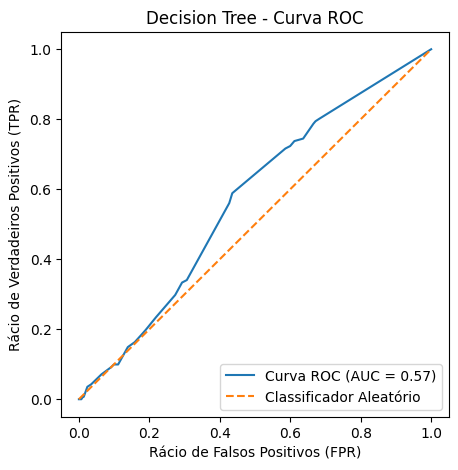

In [14]:
plot_roc_curve(decision_tree, decision_tree_name)

Efetivamente, observa-se que a *Decision Tree* apresenta um desempenho superior a um classificador aleatório, em termos de AUC.

              precision    recall  f1-score   support

           0       0.99      0.56      0.72      7202
           1       0.03      0.59      0.05       141

    accuracy                           0.57      7343
   macro avg       0.51      0.58      0.38      7343
weighted avg       0.97      0.57      0.71      7343



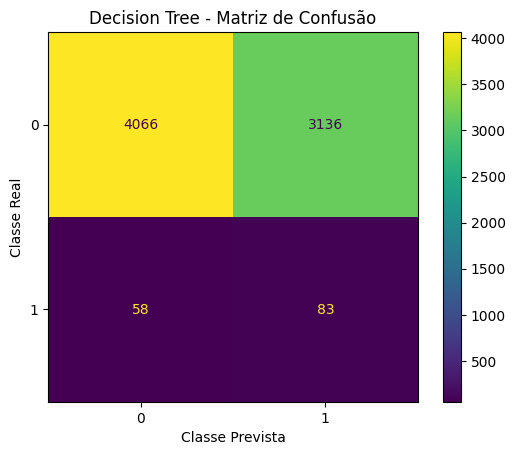

In [15]:
plot_confusion_matrix(decision_tree, decision_tree_name)

Analisando a matriz de confusão, fica claro que este modelo classificou como fraudulentas quase tantas transações legítimas (3136) como as transações legítimas que classificou corretamente (4066), o que resulta numa precisão (para a classe positiva) de 3%. Contudo, o elevado número de transações fraudulentas corretamente classificadas pela *Decision Tree* (83) resulta num *recall* de 59%. Ainda assim, as falhas já mencionadas fazem com que a exatidão seja de apenas 57%. Este desempenho ainda não é o idealmente pretendido.

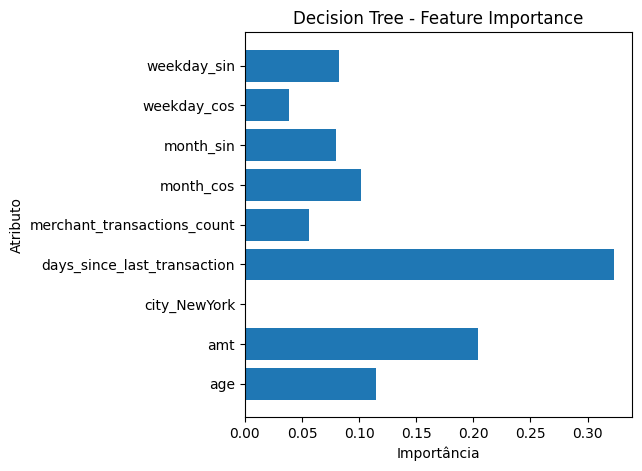

In [16]:
plot_feature_importance(decision_tree, decision_tree_name)

Observando a importância de cada atributo para o processo de classificação seguido pela *Decision Tree*, verifica-se que o número de dias desde a última transação (*days_since_last_transaction*) e a quantia da transação (*amt*) foram as colunas que tiveram mais peso, o que permite concluir que a criação deste primeiro atributo foi um sucesso. Em sentido inverso, o atributo *city_NewYork* não se mostrou, de todo, relevante para o modelo, tendo uma importância nula.

#### *Bagging*

In [17]:
bagging_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state = 10)),
    ('classifier', BaggingClassifier(DecisionTreeClassifier(criterion = 'entropy', splitter = 'best', max_depth = 10, max_features = 'sqrt', random_state = 10, class_weight = None), random_state = 10, n_jobs = -1))
])

bagging_parameter_grid = {
    'classifier__n_estimators': [10, 30, 50],
    'classifier__max_samples': [0.5, 0.75, 1.0],
    'classifier__max_features': [0.5, 0.75, 1.0],
}

bagging_name = 'Bagging'

bagging, bagging_auc = hyperparameter_tuning(bagging_pipeline, bagging_parameter_grid, bagging_name, 5)

Bagging - AUC Pré-Afinação: 0.59
Bagging (Grid Search) - Melhores Parâmetros: {'classifier__max_features': 0.75, 'classifier__max_samples': 1.0, 'classifier__n_estimators': 10}
Bagging (Grid Search) - AUC Pós-Afinação: 0.58


O modelo de *Bagging* - com a melhor *Decision Tree* identificada anteriormente como estimador (por ser instável e sensível a pequenas perturbações, logo, apropriado) - apresenta uma AUC de 0.59 antes da afinação de hiper-parâmetros, sendo que esse valor diminui ligeiramente para 0.58 após a realização de *cross-validation*. O tempo de execução é cerca de 1 minuto.

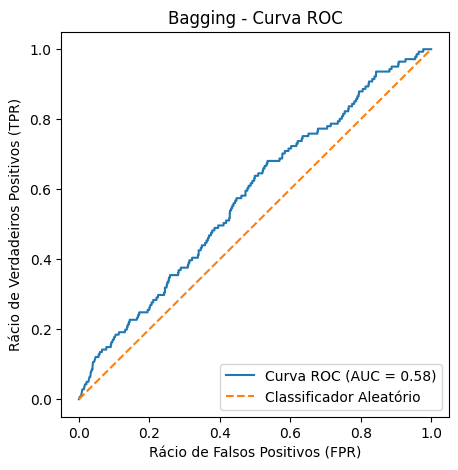

In [18]:
plot_roc_curve(bagging, bagging_name)

A curva ROC desta instância do algoritmo de *Bagging* mostra-se consideravelmente melhor do que a de um classificador aleatório.

              precision    recall  f1-score   support

           0       0.98      0.90      0.94      7202
           1       0.03      0.18      0.06       141

    accuracy                           0.89      7343
   macro avg       0.51      0.54      0.50      7343
weighted avg       0.96      0.89      0.92      7343



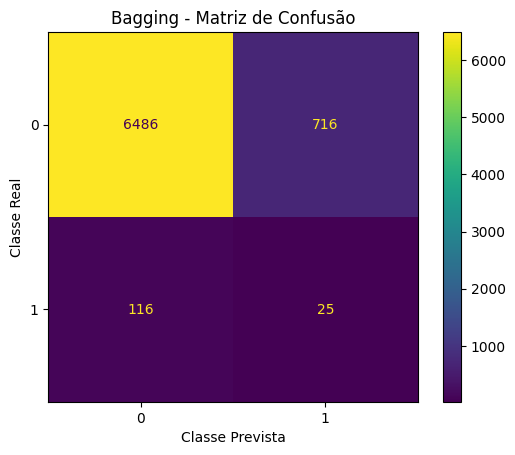

In [19]:
plot_confusion_matrix(bagging, bagging_name)

Visualizando a matriz de confusão, destaca-se que este modelo de *Bagging* classificou como fraudulentas 716 transações legítimas, o que é evidenciado pela precisão (para a classe positiva) de 3%. Para além disso, a maior parte das transações fraudulentas foram classificadas como legítimas, o que se traduz num *recall* de apenas 18%. A exatidão é de 89%, pelo que, considerando todas estas métricas de avaliação, considera-se este modelo razoável, dentro do possível.

#### *Random Forest*

In [20]:
random_forest_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state = 10)),
    ('classifier', RandomForestClassifier(random_state = 10, n_jobs = -1))
])

random_forest_parameter_grid = {
    'classifier__n_estimators': [64, 96, 128],
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__max_features': ['sqrt', 'log2'],
}

random_forest_name = 'Random Forest'

random_forest, random_forest_auc = hyperparameter_tuning(random_forest_pipeline, random_forest_parameter_grid, random_forest_name, 5)

Random Forest - AUC Pré-Afinação: 0.54
Random Forest (Grid Search) - Melhores Parâmetros: {'classifier__criterion': 'entropy', 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 64}
Random Forest (Grid Search) - AUC Pós-Afinação: 0.53


O modelo *Random Forest* - sem realizar *grid-search* e sem afinar hiper-parâmetros - retorna uma AUC de 0.54. Contudo, depois da realização de *grid-search* e da afinação de hiper-parâmetros, a AUC passa para 0.53, executando em cerca de 3 minutos.

O número de estimadores (árvores) a utilizar nesta técnica de modelação foi definida de acordo com o artigo **Oshiro, Thais & Perez, Pedro & Baranauskas, José. (2012). How Many Trees in a Random Forest?. Lecture notes in computer science. 7376. 10.1007/978-3-642-31537-4_13**, disponível em https://www.researchgate.net/publication/230766603_How_Many_Trees_in_a_Random_Forest, que conclui que o número ideal de árvores para um modelo de *Random Forest* se deve situar entre 64 e 128.

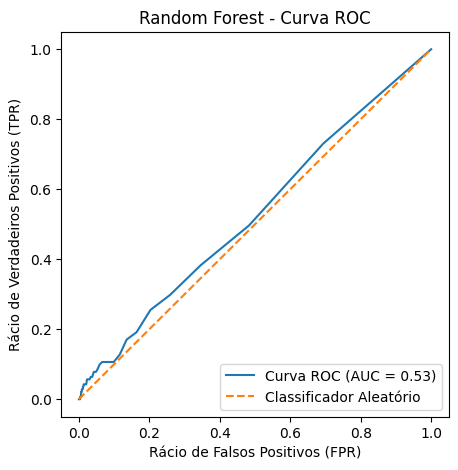

In [21]:
plot_roc_curve(random_forest, random_forest_name)

De facto, a AUC do algoritmo de *Random Forest* é ligeiramente superior à de um classificador aleatório.

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7202
           1       0.05      0.03      0.04       141

    accuracy                           0.97      7343
   macro avg       0.52      0.51      0.51      7343
weighted avg       0.96      0.97      0.97      7343



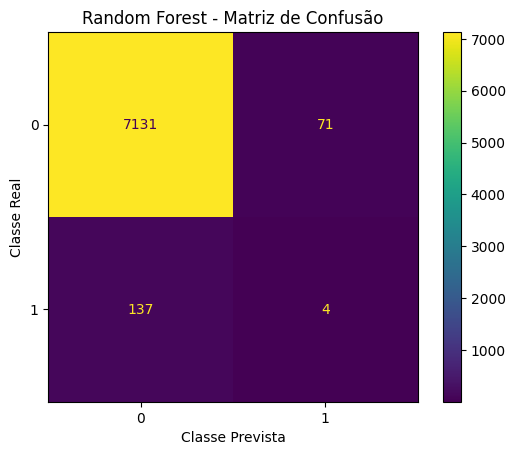

In [22]:
plot_confusion_matrix(random_forest, random_forest_name)

A matriz de confusão do modelo de *Random Forest* mostra que somente 4 transações classificadas como fraudulentas são, efetivamente, fraudulentas, pelo que a precisão (para a classe positiva) é de 5%. Assim, houve 137 transações fraudulentas classificadas como legítimas, levando ao valor de *recall* de 3%. A exatidão é de 97%, pelas razões já explicitadas relativamente ao desequilíbrio do conjunto de dados e à facilidade em obter uma exatidão extremamente alta (98%) ao classificar todas as transações como legítimas, não estando este modelo muito distante disso mesmo. Como tal, este modelo não pode ser considerado positivo/satisfatório.

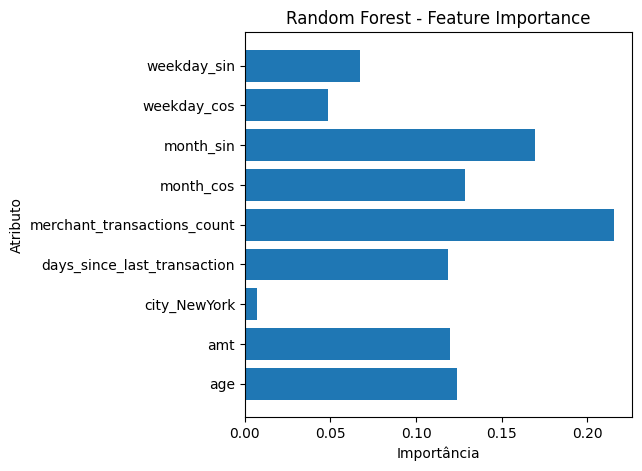

In [23]:
plot_feature_importance(random_forest, random_forest_name)

A *feature importance* obtida pelo modelo *Random Forest* mostra que o atributo mais preponderante para a classificação foi o número de transações efetuadas até ao momento por cada cliente em cada comerciante (*merchant_transactions_count*), seguido das restantes funcionalidades que foram criadas, o que permite concluir que o processo de engenharia de funcionalidades foi extremamente útil para a modelação preditiva. Contudo, tal como anteriormente, o atributo *city_NewYork* não demonstra muita relevância, pelo que, em iterações futuras, poderá ser desconsiderado.

#### *AdaBoost*

In [24]:
adaboost_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state = 10)),
    ('classifier', AdaBoostClassifier(random_state = 10))
])

adaboost_parameter_grid = {
    'classifier__estimator': [
        None,
        DecisionTreeClassifier(criterion = 'entropy', splitter = 'best', max_depth = 5, max_features = 'sqrt', random_state = 10, class_weight = None),
        DecisionTreeClassifier(criterion = 'entropy', splitter = 'best', max_depth = 10, max_features = 'sqrt', random_state = 10, class_weight = None),
    ],
    'classifier__n_estimators': [25, 50, 75],
    'classifier__learning_rate': [0.75, 1.0, 1.25]
}

adaboost_name = 'AdaBoost'

adaboost, adaboost_auc = hyperparameter_tuning(adaboost_pipeline, adaboost_parameter_grid, adaboost_name, 5)

AdaBoost - AUC Pré-Afinação: 0.57
AdaBoost (Grid Search) - Melhores Parâmetros: {'classifier__estimator': DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features='sqrt',
                       random_state=10), 'classifier__learning_rate': 1.0, 'classifier__n_estimators': 25}
AdaBoost (Grid Search) - AUC Pós-Afinação: 0.54


O algoritmo *AdaBoost* obtém uma AUC de 0.57, pré-afinação de hiper-parâmetros, passando este valor para 0.54, após a afinação de hiper-parâmetros e a realização de *grid-search*. Esta técnica demora cerca de 2 minutos a executar.

Foi experimentado o estimador predefinido para este modelo (uma *Decision Tree* inicializada com `max_depth = 1`), bem como a melhor *Decision Tree* encontrada até ao momento e um classificador semelhante a este, mas com metade da profundidade máxima.

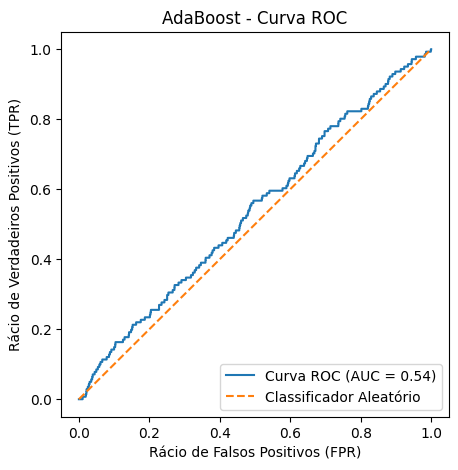

In [25]:
plot_roc_curve(adaboost, adaboost_name)

A AUC desta técnica de modelação *AdaBoost* é notoriamente maior do que a métrica correspondente de um classificador aleatório.

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      7202
           1       0.01      0.01      0.01       141

    accuracy                           0.96      7343
   macro avg       0.50      0.50      0.50      7343
weighted avg       0.96      0.96      0.96      7343



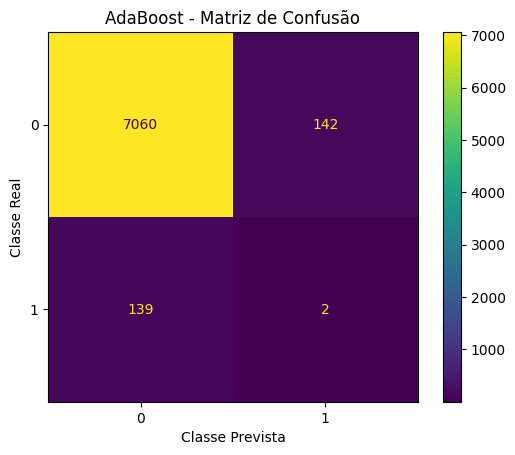

In [26]:
plot_confusion_matrix(adaboost, adaboost_name)

Considerando a matriz de confusão, salienta-se que o *AdaBoost* falhou em quase todas as transações fraudulentas previstas (142), daí ter obtido uma precisão (para a classe positiva) de 1%. Além disso, 139 transações fraudulentas foram previstas como sendo legítimas, o que levou ao *recall* de 1%. Globalmente - desconsiderando a exatidão de 96%, pelos motivos já evidenciados, devido ao desequilíbrio dos dados -, o desempenho do modelo pode ser definido como insuficiente.

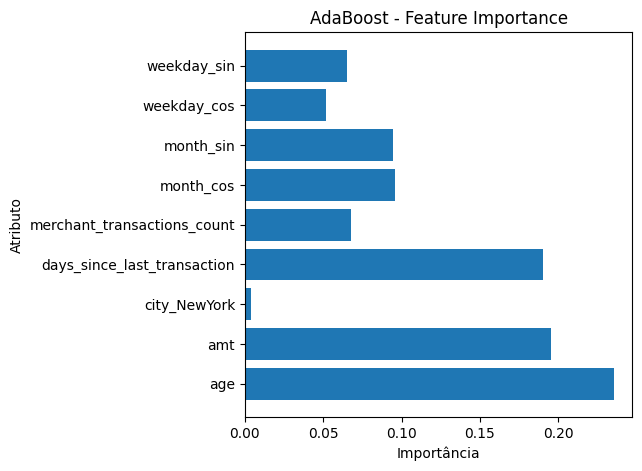

In [27]:
plot_feature_importance(adaboost, adaboost_name)

Observando a importância de cada atributo para o *AdaBoost*, verifica-se que as colunas *age* e *amt* foram as mais decisivas, imediatamente seguidas pelo atributo *days_since_last_transaction*. Isto sustenta a conclusão de que a criação destas funcionalidades - idade e número de dias desde a última transação - fez sentido e acrescentou valor ao modelo, bem como a manutenção da variável com a quantia de cada transação. Em sentido inverso, a coluna *city_NewYork* mostrou-se, mais uma vez, praticamente inútil.

#### *Gradient Boosting*

In [28]:
gradient_boosting_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state = 10)),
    ('classifier', GradientBoostingClassifier(random_state = 10, max_features = 'sqrt', warm_start = True))
])

gradient_boosting_parameter_grid = {
    'classifier__loss': ['log_loss', 'exponential'],
    'classifier__learning_rate': [0.1, 0.2],
    'classifier__n_estimators': [100, 200, 300, 400]
}

gradient_boosting_name = 'Gradient Boosting'

gradient_boosting, gradient_boosting_auc = hyperparameter_tuning(gradient_boosting_pipeline, gradient_boosting_parameter_grid, gradient_boosting_name, 5)

Gradient Boosting - AUC Pré-Afinação: 0.58
Gradient Boosting (Grid Search) - Melhores Parâmetros: {'classifier__learning_rate': 0.2, 'classifier__loss': 'exponential', 'classifier__n_estimators': 300}
Gradient Boosting (Grid Search) - AUC Pós-Afinação: 0.55


Antes da afinação de hiper-parâmetros, o modelo de *Gradient Boosting* retorna uma AUC de 0.58. Todavia, após a afinação de hiper-parâmetros, o valor obtido para a AUC decresce para a 0.55, o que se deverá ao facto de os melhores hiper-parâmetros para o conjunto de treino não coincidirem com os melhores hiper-parâmetros para o conjunto de teste. O tempo de execução encontra-se entre 2 e 3 minutos.

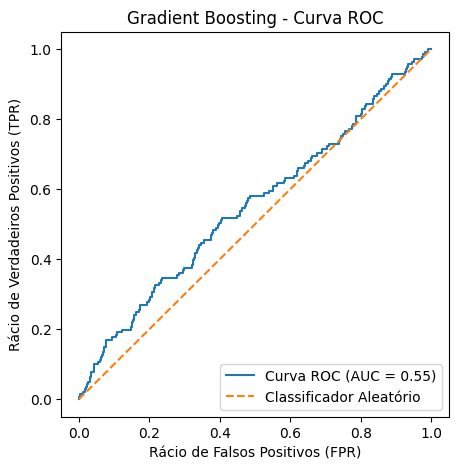

In [29]:
plot_roc_curve(gradient_boosting, gradient_boosting_name)

A AUC deste modelo de *Gradient Boosting* é evidentemente maior do que a de um classificador aleatório.

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      7202
           1       0.03      0.03      0.03       141

    accuracy                           0.96      7343
   macro avg       0.51      0.51      0.51      7343
weighted avg       0.96      0.96      0.96      7343



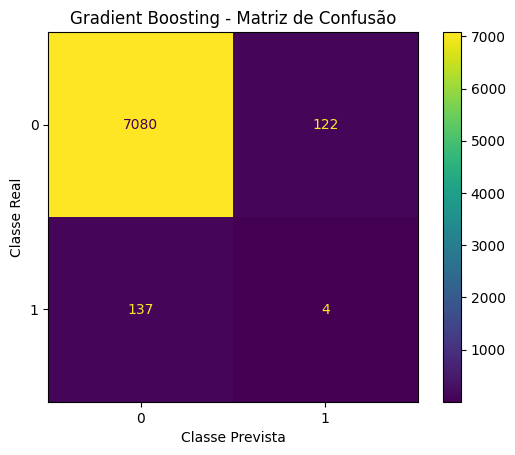

In [30]:
plot_confusion_matrix(gradient_boosting, gradient_boosting_name)

A matriz de confusão deste *Gradient Boosting* mostra que existem transações legítimas classificadas como fraudulentas e vice-versa. Assim sendo, os valores de precisão e de *recall* (para a classe positiva) são ambos 3%. O valor obtido para a exatidão é 96% - ainda que a pouca relevância desta métrica já tenha sido discutida -, pelo que este modelo também não é ótimo.

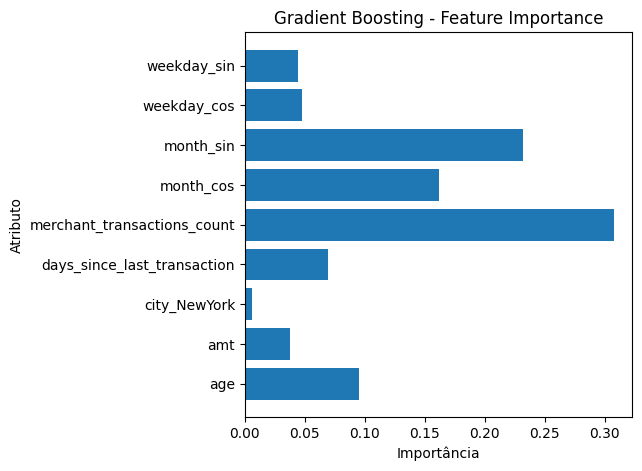

In [31]:
plot_feature_importance(gradient_boosting, gradient_boosting_name)

Tal como anteriormente, a *feature importance* do modelo evidencia uma clara tendência para os atributos criados no processo de construção de novos dados se afigurarem relevantes para a classificação das transações. Efetivamente, a coluna *merchant_transactions_count* mostra-se, mais uma vez, extremamente importante, assim como a codificação cíclica do mês em que foi efetuada cada transação (*month_sin* e *month_cos*). No entanto, no seguimento do anteriormente observado, a funcionalidade *city_NewYork* tem importância extremamente reduzida.

#### *Support Vector Machine*

In [32]:
svm_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state = 10)),
    ('classifier', SVC(probability = True, random_state = 10))
])

svm_parameter_grid = {
    'classifier__C': [0.01, 0.1, 1],
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

svm_name = 'Support Vector Machine'

svm, svm_auc = hyperparameter_tuning(svm_pipeline, svm_parameter_grid, svm_name, 5, 0.25)

Support Vector Machine - AUC Pré-Afinação: 0.56
Support Vector Machine (Grid Search) - Melhores Parâmetros: {'classifier__C': 0.01, 'classifier__kernel': 'sigmoid'}
Support Vector Machine (Grid Search) - AUC Pós-Afinação: 0.54


Antes da afinação de hiper-parâmetros e da realização de *grid-search*, a *Support Vector Machine* consegue uma AUC de 0.56. Depois, esta métrica decresce ligeiramente para 0.54, demorando cerca de 5 minutos a executar.

Note-se que, dada a complexidade computacional deste modelo, para reduzir o tempo computacional e tornar esta técnica viável, o processo de *cross-validation* foi realizado com apenas um quarto (25%) do conjunto de dados inicial.

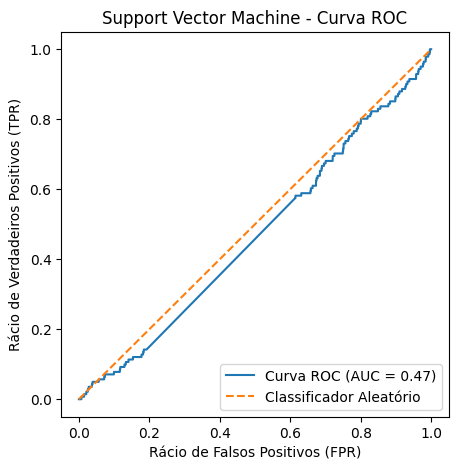

In [33]:
plot_roc_curve(svm, svm_name)

A curva ROC desta *Support Vector Machine* mostra-se, quando testada no conjunto completo de dados, ligeiramente pior do que a de um classificador aleatório.

              precision    recall  f1-score   support

           0       0.99      0.19      0.32      7202
           1       0.02      0.86      0.04       141

    accuracy                           0.20      7343
   macro avg       0.50      0.52      0.18      7343
weighted avg       0.97      0.20      0.31      7343



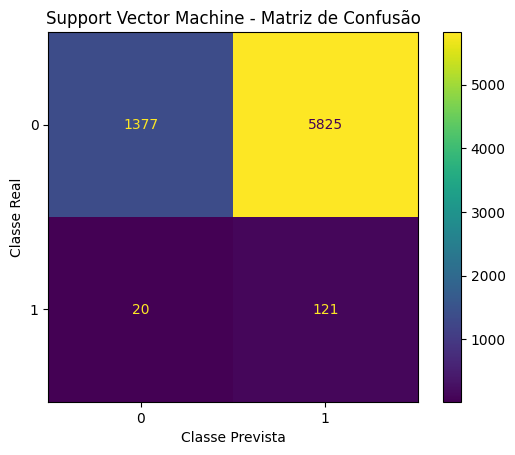

In [34]:
plot_confusion_matrix(svm, svm_name)

No que diz respeito à matriz de confusão da *Support Vector Machine*, salienta-se que quase não ocorreram falsos negativos, isto é, transações fraudulentas classificadas como legítimas (20), mas houve vários falsos positivos (transações legítimas classificadas como fraudulentas - 5825). Como tal, este modelo apresenta (para a classe positiva) um *recall* de 86% - porque capturou quase a totalidade das transações fraudulentas -, mas uma precisão de apenas 2% - porque classificou como fraudulentas muitas transações legítimas. Assim, resultando numa exatidão de 20%, este modelo tem um desempenho que não é satisfatório.

#### *Artificial Neural Network*

In [35]:
neural_network_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state = 10)),
    ('classifier', MLPClassifier(random_state = 10))
])

neural_network_parameter_grid = {
    'classifier__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'classifier__solver': ['lbfgs', 'sgd', 'adam'],
    'classifier__learning_rate': ['constant', 'invscaling', 'adaptive']
}

neural_network_name = 'Artificial Neural Network'

neural_network, neural_network_auc = hyperparameter_tuning(neural_network_pipeline, neural_network_parameter_grid, neural_network_name, 5, 0.25)

Artificial Neural Network - AUC Pré-Afinação: 0.55
Artificial Neural Network (Grid Search) - Melhores Parâmetros: {'classifier__activation': 'relu', 'classifier__learning_rate': 'constant', 'classifier__solver': 'adam'}
Artificial Neural Network (Grid Search) - AUC Pós-Afinação: 0.55


A *Artificial Neural Network* apresenta um resultado de AUC de 0.55, antes e depois da afinação de hiper-parâmetros, tendo um tempo de execução de cerca de 3/4 minutos.

Veja-se que, tal como anteriormente, de modo a minimizar o custo computacional para viabilizar a execução desta técnica, o processo de *cross-validation* foi realizado com apenas um quarto (25%) do conjunto de dados.

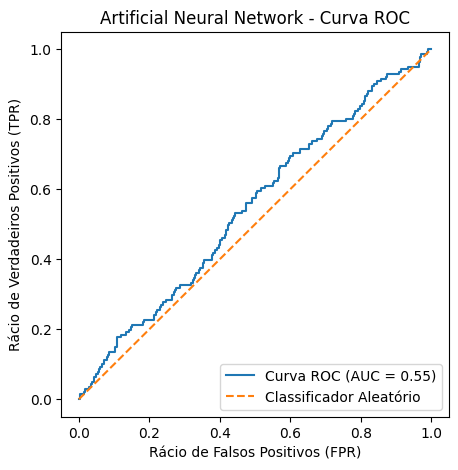

In [36]:
plot_roc_curve(neural_network, neural_network_name)

Ora, a curva ROC da *Neural Network* é substancialmente melhor do que a curva ROC de um classificador aleatório.

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      7202
           1       0.03      0.18      0.05       141

    accuracy                           0.86      7343
   macro avg       0.50      0.53      0.49      7343
weighted avg       0.96      0.86      0.91      7343



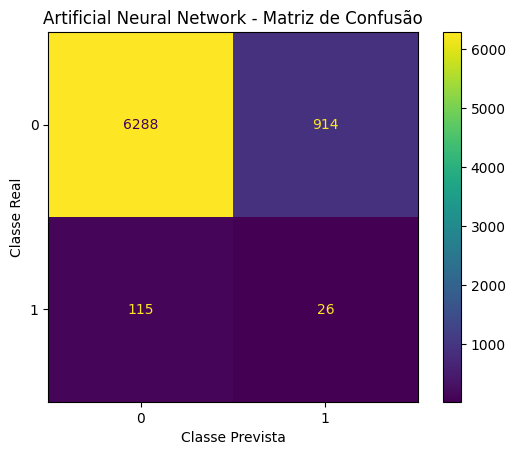

In [37]:
plot_confusion_matrix(neural_network, neural_network_name)

Interpretando a matriz de confusão associada à *Artificial Neural Network*, constata-se que ocorreram alguns erros de falsos positivos (914) - transações legítimas classificadas como fraudulentas - e de falsos negativos (115) - transações fraudulentas classificadas como legítimas -, tal como é visível nas métricas (para a classe positiva) de precisão (3%) e *recall* (18%). Efetivamente, embora a exatidão seja 86%, os valores obtidos para estas métricas de desempenho não são muito satisfatórios, dado que o modelo ainda comete um número considerável de erros.

#### *Voting*

In [38]:
voting_pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state = 10)),
    ('classifier', VotingClassifier([('gnb', GaussianNB()), ('dt', DecisionTreeClassifier(criterion = 'entropy', splitter = 'best', max_depth = 10, max_features = 'sqrt', random_state = 10, class_weight = None)), ('rf', RandomForestClassifier(n_estimators = 64, criterion = 'entropy', max_features = 'sqrt', random_state = 10))], voting = 'soft', n_jobs = -1))
])

voting_parameter_grid = {
    'classifier__estimators': [
        [('gnb', GaussianNB()), ('dt', DecisionTreeClassifier(criterion = 'entropy', splitter = 'best', max_depth = 10, max_features = 'sqrt', random_state = 10, class_weight = None)), ('rf', RandomForestClassifier(n_estimators = 64, criterion = 'entropy', max_features = 'sqrt', random_state = 10))],
        [('dt', DecisionTreeClassifier(criterion = 'entropy', splitter = 'best', max_depth = 10, max_features = 'sqrt', random_state = 10, class_weight = None)), ('b', BaggingClassifier(DecisionTreeClassifier(criterion = 'entropy', splitter = 'best', max_depth = 10, max_features = 'sqrt', random_state = 10, class_weight = None), n_estimators = 10, max_samples = 1.0, max_features = 0.75, random_state = 10, n_jobs = -1)), ('gb', GradientBoostingClassifier(loss = 'exponential', learning_rate = 0.2, n_estimators = 300, random_state = 10, max_features = 'sqrt', warm_start = True))]
    ],
    'classifier__weights': [[1, 1, 1], [2, 1, 1], [1, 2, 1], [1, 1, 2], [1, 2, 2], [2, 1, 2], [2, 2, 1]],
}

voting_name = 'Voting'

voting, voting_auc = hyperparameter_tuning(voting_pipeline, voting_parameter_grid, voting_name, 5)

Voting - AUC Pré-Afinação: 0.55
Voting (Grid Search) - Melhores Parâmetros: {'classifier__estimators': [('dt', DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features='sqrt',
                       random_state=10)), ('b', BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                   max_depth=10,
                                                   max_features='sqrt',
                                                   random_state=10),
                  max_features=0.75, n_jobs=-1, random_state=10)), ('gb', GradientBoostingClassifier(learning_rate=0.2, loss='exponential',
                           max_features='sqrt', n_estimators=300,
                           random_state=10, warm_start=True))], 'classifier__weights': [1, 2, 2]}
Voting (Grid Search) - AUC Pós-Afinação: 0.57


Pré-afinação de hiper-parâmetros, este modelo de *Voting* (com os classificadores *Naive Bayes*, *Decision Tree* e *Random Forest*) retorna uma AUC de 0.55. Pós-afinação, o *Voting* considera melhor a combinação dos classificadores *Decision Tree*, *Bagging* e *Gradient Boosting*, obtendo uma AUC de 0.57, em cerca de 2 ou 3 minutos.

Foram experimentadas combinações das melhores técnicas de modelação encontradas até ao momento.

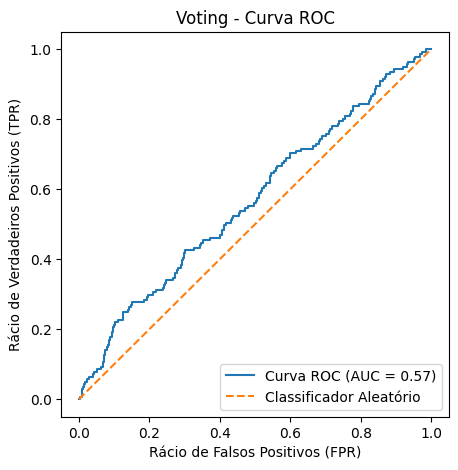

In [39]:
plot_roc_curve(voting, voting_name)

Em comparação com a curva ROC de um classificador aleatório, esta mesma curva para o modelo de *Voting* demonstra-se muito melhor.

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      7202
           1       0.05      0.04      0.05       141

    accuracy                           0.97      7343
   macro avg       0.52      0.51      0.51      7343
weighted avg       0.96      0.97      0.96      7343



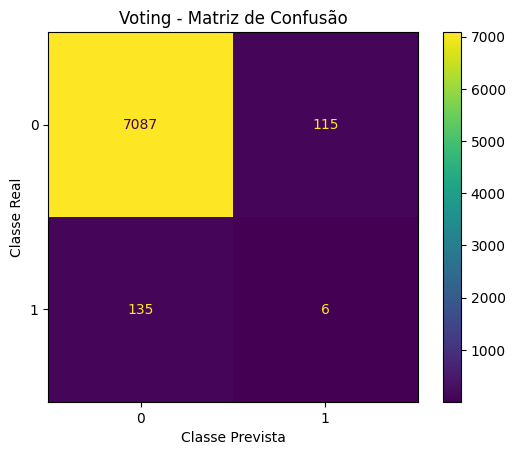

In [40]:
plot_confusion_matrix(voting, voting_name)

Por último, a matriz de confusão do modelo de *Voting* transmite a existência de erros dos dois tipos possíveis (falsos positivos e falsos negativos). Deste modo, 115 transações legítimas classificadas como fraudulentas resultam numa precisão (para a classe positiva) de 5% e 135 transações fraudulentas classificadas como legítimas resultam num *recall* (para a classe positiva) de 4%. Assim, embora estes valores não sejam bons, o modelo apresenta uma exatidão de 97%, pelas razões já evidenciadas, sendo a sua relevância quase negligenciável.

### Avaliação dos Modelos

Agora que todos os modelos foram devidamente treinados e testados, é possível resumir os resultados obtidos para cada um deles, no que diz respeito às métricas de avaliação consideradas.

| Modelo | AUC | Precisão | *Recall* | Exatidão | Tempo de Execução (Aproximado) |
| ------ | --- | -------- | -------- | -------- | ------------------------------ |
| ***K-Nearest Neighbors*** | 0.52 | 3% | 16% | 88% | 30 segundos |
| ***Naive Bayes*** | 0.56 | 2% | 79% | 28% | 5 segundos |
| ***Decision Tree*** | 0.57 | 3% | 59% | 57% | 10 segundos |
| ***Bagging*** | 0.58 | 3% | 18% | 89% | 1 minuto |
| ***Random Forest*** | 0.53 | 5% | 3% | 97% | 3 minutos |
| ***AdaBoost*** | 0.54 | 1% | 1% | 96% | 2 minutos |
| ***Gradient Boosting*** | 0.55 | 3% | 3% | 96% | 2,5 minutos |
| ***Support Vector Machine*** | 0.54 | 2% | 86% | 20% | 5 minutos |
| ***Artificial Neural Network*** | 0.55 | 3% | 18% | 86% | 3,5 minutos |
| ***Voting*** | 0.57 | 5% | 4% | 97% | 2,5 minutos |

Analisando a tabela com a síntese dos resultados obtidos por cada técnica de modelação, verifica-se que os modelos de *ensemble* - em particular *Bagging* - são aqueles que apresentam um melhor desempenho em termos de AUC. Isto porque este modelo é o único que retorna uma AUC de 0.58, o que o torna o melhor para o problema de classificação a tratar, até porque o tempo que demora a executar é admissível/viável.

Para além deste, a *Decision Tree* e a técnica de modelação *Voting* têm avaliações extremamente próximas das dos modelos anteriores (AUC = 0.57), pelo que também podem ser consideradas positivas. Efetivamente, a *Decision Tree* apresenta um *recall* mais elevado (59%), com o *trade-off* de ter uma exatidão inferior (57%). A par disto, estas técnicas também são relativamente rápidas.

O algoritmo *Naive Bayes* também tem um bom desempenho, por conseguir uma AUC de 0.56, sendo extremamente rápido, o que facilita a sua aplicação prática. No entanto, tal como a *Decision Tree*, atinge um *recall* elevado (78%) em troca de uma exatidão muito reduzida (28%).

O *Gradient Boosting* e a *Artificial Neural Network* obtêm uma AUC de 0.55, não se destacando pela positiva nem pela negativa; têm um desempenho razoável.

Os modelos *AdaBoost* e *Support Vector Machine* têm uma AUC de 0.54, mas uma precisão extremamente baixa (1% ou 2%). Por um lado, o primeiro algoritmo tem um *recall* de apenas 1%, o que o torna praticamente inútil, apesar da exatidão de 96%. Por outro lado, embora consiga um *recall* de 86%, a segunda técnica apresenta uma exatidão de só 20% e demora cerca de 5 minutos a executar (com apenas uma fração do conjunto de dados), pelo que a sua aplicabilidade prática também é duvidosa.

A *Random Forest* tem um desempenho fraco - AUC de 0.53, complementada por valores de precisão (5%) e *recall* (3%) igualmente baixos - e tem um tempo de execução que não justifica a sua implementação, dados os resultados que obtém.

Finalmente, o algoritmo *K-Nearest Neighbors* é aquele que apresenta os piores resultados em termos de AUC, embora seja rápido a executar.

Assim, é possível ordenar os modelos por ordem decrescente de AUC, de maneira a verificar o cumprimento dos objetivos de mineração de dados:
1. *Bagging* - 0.58
2. *Decision Tree* e *Voting* - 0.57
3. *Naive Bayes* - 0.56
4. *Gradient Boosting* e *Artificial Neural Network*- 0.55
5. *AdaBoost* e *Support Vector Machine* - 0.54
6. *Random Forest* - 0.53
7. *K-Nearest Neighbors* - 0.52

Como todos os modelos apresentam um desempenho melhor do que um classificador aleatório (AUC > 0.5), podem ser considerados finais e submetidos à próxima fase de avaliação.

## Avaliação

### Avaliação dos Resultados

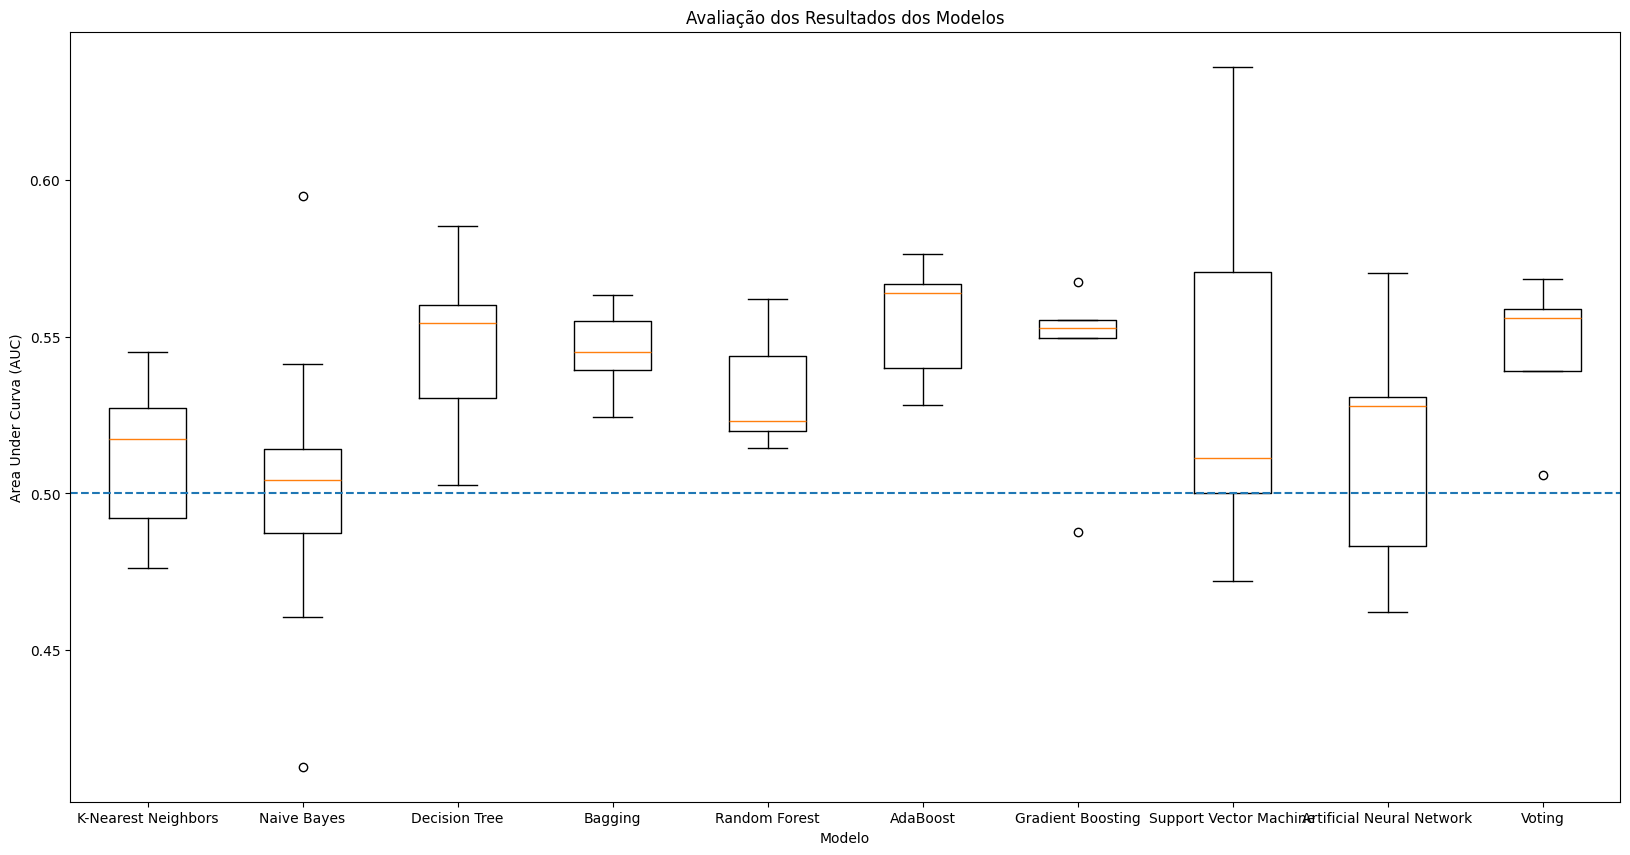

In [41]:
models = [knn, naive_bayes, decision_tree, bagging, random_forest, adaboost, gradient_boosting, svm, neural_network, voting]
labels = [knn_name, naive_bayes_name, decision_tree_name, bagging_name, random_forest_name, adaboost_name, gradient_boosting_name, svm_name, neural_network_name, voting_name]

scores = []
for model in models:
    score = [
        model.cv_results_[f'split{i}_test_score'][model.best_index_]
        for i in range(model.n_splits_)
    ]
    scores.append(score)

plt.figure(figsize = (20, 10))
plt.boxplot(scores, labels = labels)
plt.axhline(0.5, linestyle = '--')
contextualize('Avaliação dos Resultados dos Modelos', 'Modelo', 'Area Under Curva (AUC)')

Observando o diagrama de caixa e bigodes para os resultados do desempenho de cada modelo, é possível comparar a consistência de cada uma das técnicas de modelação. O diagrama apresenta, para cada modelo, o resultado obtido para a AUC em cada uma das *k* partições do conjunto de dados, considerando os melhores parâmetros determinados através de *grid-search*.

Efetivamente, verifica-se que os modelos de *ensemble* (nomeadamente *Bagging*, *AdaBoost*, *Gradient Boosting* e *Voting*) são os melhores para o problema de classificação a tratar, dado que são aqueles que obtêm consistentemente a AUC mais elevada. De seguida, a *Decision Tree* é a técnica de modelação que consegue os melhores resultados, mas com uma variabilidade/instabilidade considerável, dependendo do conjunto de dados em que é testada. O modelo *Random Forest* evidencia uma muito menor variabilidade, mas também um resultado médio inferior. A *Support Vector Machine* e a *Artificial Neural Network* demonstram uma clara instabilidade, sendo altamente dependentes do conjunto de teste. Finalmente, os algoritmos *K-Nearest Neighbors* e *Naive Bayes* são aqueles que evidenciam um pior desempenho quanto à métrica de avaliação considerada, por serem, em média, os mais próximos de um classificador aleatório.

Assim, é possível ordenar os modelos de acordo com a sua adequação aos objetivos do tema. O critério principal de avaliação é a área sobre a curva ROC, tal como definido anteriormente, de modo a aferir quão bem cada modelo distingue transações fraudulentas de transações legítimas. O critério de desempate (para modelos com igual AUC) é o valor obtido para *recall*, tendo em conta que é mais importante capturar todas as transações fraudulentas, ainda que correndo o risco de incluir algumas transações legítimas, do que só identificar as transações garantidamente fraudulentas, mas deixando escapar algumas transações fraudulentas. Em caso de igualdade nestas duas métricas, o terceiro critério utilizado para a ordenação será a precisão, visto que também é importante não considerar fraudulentas transações que são legítimas, na tentativa de minimizar o impacto desta deteção de fraude para os utilizadores legítimos.

Deste modo, a ordem dos modelos - do mais adequado para o menos adequado - é a seguinte:
1. *Bagging*
2. *Decision Tree*
3. *Voting*
4. *Naive Bayes*
5. *Artificial Neural Network*
6. *Gradient Boosting*
7. *Support Vector Machine*
8. *AdaBoost*
9. *Random Forest*
10. *K-Nearest Neighbors*

No geral, estes resultados parecem satisfazer os objetivos pretendidos para o tema, dado que todos os modelos conseguem distinguir transações fraudulentas de legítimas com alguma informação, isto é, são melhores do que um classificador aleatório, dado que a AUC de todos os modelos é superior a 0.5. Para além disso, todas as técnicas de modelação executam em tempo útil (menos do que 5 minutos), o que viabiliza a sua aplicação prática em contexto real.

### Revisão do Processo

No final do processo de aprendizagem computacional, torna-se oportuno e adequado efetuar uma reflexão/revisão sobre todo o trabalho desenvolvido, destacando as atividades principais e as decisões tomadas em cada fase, considerando aspetos positivos e aspetos a melhorar.

1. **Compreensão do Tema:** Nesta fase, estabeleceram-se os objetivos do tema e os objetivos de mineração de dados. Efetivamente, esta etapa foi crucial para clarificar aquilo que se pretendia do projeto a desenvolver, através da definição dos critérios de sucesso do mesmo. Assim, foi importante tornar claro aquilo que se considerava uma "fraude" e que deveria ser detetado pelo modelo, bem como qual era a importância do desenvolvimento do mesmo. Não se verificaram dificuldades, nem aspetos a melhorar no futuro.

2. **Compreensão dos Dados:** Esta etapa - extremamente abrangente e demorada - teve como propósito aumentar o conhecimento sobre o domínio e, em particular, sobre os dados a tratar, permitindo a formulação de hipóteses/teorias e a extração de conclusões. Nesse sentido, a elaboração de vários gráficos e tabelas permitiu responder às questões colocadas através de análises estatísticas descritivas. Para além disso, a reflexão sobre a plausibilidade de alguns valores, assim como a aferição da qualidade dos dados, foram elementos essenciais para realizar uma boa preparação do conjunto de dados, resultando, posteriormente, numa boa modelação. No futuro, talvez pudessem ser formalizadas mais teorias e levantadas mais questões/hipóteses sobre os dados e o problema a tratar, procurando, desse modo, ter um ainda maior conhecimento do domínio, para uma ainda melhor modelação.

3. **Preparação dos Dados:** Neste momento, os dados foram selecionados, limpos, construídos/transformados, integrados e formatados. Isto foi essencial para possibilitar a aplicação das diferentes técnicas de modelação, garantido que os dados estavam prontos para serem ingeridos pelos diferentes modelos. Ora, este processo foi ligeiramente desafiante, principalmente no sentido de determinar que funcionalidades fariam sentido serem criadas seguindo uma metodologia de engenharia de funcionalidades, pelo que, em trabalhos posteriores, pode ser relevante procurar mais informações com peritos do domínio em questão. Ainda que todas as decisões tenham sido devidamente fundamentadas e justificadas, admite-se que, em eventuais iterações futuras, estas possam ser tomadas de forma diferente, tendo em vista a obtenção de melhores resultados. Por exemplo, em vez de eliminar o atributo *device_os*, por ter mais de metade dos valores em falta, estes valores poderiam ter sido imputados com o valor mais comum para este atributo nas transações semelhantes, o que retornaria resultados diferentes. Para além disso, poderia ter sido criada uma *pipeline* que automatizasse todo este processo de preparação dos dados, tal como será feito na fase de produção.

4. **Modelação Preditiva:** Esta parte - central e imprescindível - serviu para desenvolver os dez modelos de classificação a testar: *K-Nearest Neighbors*, *Naive Bayes*, *Decision Tree*, *Bagging*, *Random Forest*, *AdaBoost*, *Gradient Boosting*, *Support Vector Machine*, *Artificial Neural Network* e *Voting*. Todas estas técnicas de modelação foram treinadas e testadas contra um *design* de teste previamente elaborado, para que pudessem ser avaliadas e comparadas devidamente. Assim, foram determinados os valores de várias métricas de avaliação (dando particular destaque à AUC) para cada um dos algoritmos considerados e afinados os hiper-parâmetros com uma *grid search*, tendo em vista a maximização do valor da área sobre a curva ROC. Se o tempo o permitir, trabalhos futuros podem explorar ainda mais modelos, bem como afiná-los com hiper-parâmetros distintos e/ou fornecendo-lhes dados diferentes. Ainda assim, esta etapa pode ser considerada globalmente completa e bem-sucedida.

5. **Avaliação:** Finalmente, a última secção permitiu comparar os resultados obtidos pelos diferentes modelos e verificar a sua adequação aos objetivos do tema, tendo em vista a definição de qual o modelo com melhor desempenho. Assim, concluiu-se o processo de aprendizagem computacional de forma apropriada, resumindo os resultados, agregando-os e evidenciando-os de forma clara.

### Determinação dos Próximos Passos

Concluído todo o processo, resta seguir para a fase de produção, não sem antes resumir os aspetos que podem ser considerados em iterações futuras deste mesmo projeto.

Em síntese, podem ser exploradas diferentes variações dos dados fornecidos ao modelo, seja pela remoção ou manutenção de determinados atributos, seja pela criação de novas e diferentes funcionalidades. Em particular, este aspeto talvez seja o mais importante a considerar em trabalhos futuros, tendo em vista a obtenção de melhores resultados, dado que os novos atributos criados mostraram-se cruciais para os resultados obtidos pelas diferentes técnicas de modelação, tal como se comprova pelos gráficos de *feature importance*. A par disso, pode também ser desenvolvida uma *pipeline* para otimizar todo o processo de preparação de dados, como se fará agora para a entrada em produção do modelo.

Não havendo nada mais a tratar, avança-se para o momento final do projeto.

## Produção

Tendo treinado, testado e avaliado os modelos, bem como estabelecido a sua ordem de adequação ao problema de mineração de dados a tratar, tendo em conta o desempenho obtido, o modelo considerado final deve ser colocado em produção, isto é, ser submetido na competição do *Kaggle* presente neste *link*: https://www.kaggle.com/competitions/fraud-detection-cc-4036-2425.

Os ficheiros de dados relevantes encontram-se no diretório **kaggle**, sendo os seguintes:
1. **customers.csv:** ficheiro de clientes devidamente tratado, guardado/exportado após o final da *Task 1*
2. **merchants.csv:** ficheiro de comerciantes devidamente tratado, guardado/exportado após o final da *Task 1*
3. **test_transactions.csv:** transações não classificadas, com as quais o modelo será testado na competição do *Kaggle*

Assim, os dados presentes no ficheiro **test_transactions.csv** devem ser devidamente selecionados, limpos, construídos, integrados e formatados, de acordo com o procedimento seguido na *Task 1*, sendo, agora, efetuado através de uma *pipeline*.

In [42]:
customers = pd.read_csv('kaggle/customers.csv')
merchants = pd.read_csv('kaggle/merchants.csv')
transactions = pd.read_csv('kaggle/test_transactions.csv')

def data_selection(transactions):
    return transactions.drop(['trans_date_trans_time', 'device_os'], axis = 1)

def data_cleaning(transactions):
    return transactions.drop('trans_num', axis = 1)

def data_construction(transactions):
    timestamp = pd.to_datetime(transactions['unix_time'], unit = 's')
    
    month = (timestamp.dt.month - 1) * (2 * np.pi / 12)
    transactions['month_sin'] = round(np.sin(month), 3)
    transactions['month_cos'] = round(np.cos(month), 3)

    weekday = timestamp.dt.weekday * (2 * np.pi / 7)
    transactions['weekday_sin'] = round(np.sin(weekday), 3)
    transactions['weekday_cos'] = round(np.cos(weekday), 3)

    transactions = transactions.sort_values(by = ['cc_num', 'unix_time'])
    transactions['days_since_last_transaction'] = transactions.groupby('cc_num')['unix_time'].diff()
    transactions['days_since_last_transaction'] = round(transactions['days_since_last_transaction'] / (60 * 60 * 24), 3)
    transactions['days_since_last_transaction'] = transactions['days_since_last_transaction'].fillna(0)

    transactions = transactions.sort_values(by = ['cc_num', 'merchant', 'unix_time'])
    transactions['merchant_transactions_count'] = transactions.groupby(['cc_num', 'merchant']).cumcount()

    return transactions

def data_integration(transactions, merchants, customers):
    data = transactions.merge(merchants, on = 'merchant').merge(customers, on = 'cc_num')
    data['age'] = pd.to_datetime(data['unix_time'], unit = 's').dt.year - pd.to_datetime(data['dob']).dt.year
    data['city_NewYork'] = (data['city'] == 'New York').astype(int)
    data = data.drop(['dob', 'unix_time', 'cc_num', 'job', 'category', 'gender', 'city'], axis = 1)
    return data

def data_formatting(test_data):
    test_data = test_data.drop('merchant', axis = 1)
    test_data = pd.get_dummies(test_data, drop_first = True)
    test_data = test_data.sort_index(axis = 1)
    return test_data

test_data = transactions.pipe(data_selection).pipe(data_cleaning).pipe(data_construction).pipe(data_integration, merchants, customers).pipe(data_formatting)
test_data.head()

,age,amt,city_NewYork,days_since_last_transaction,index,merchant_transactions_count,month_cos,month_sin,weekday_cos,weekday_sin
0,30,483.368265,0,0.0,31604,0,0.866,-0.500,-0.223,0.975
1,20,236.803300,0,171.0,30246,0,-0.866,-0.500,-0.901,0.434
2,20,181.193456,0,0.0,30526,0,0.866,0.500,1.000,0.000
3,28,22.241488,0,0.0,30566,0,-0.500,-0.866,-0.223,-0.975
4,68,293.482287,0,0.0,30106,0,1.000,0.000,0.623,0.782


Finalmente, as transações a testar na competição do *Kaggle* devem ser submetidas ao modelo a colocar em produção, para que seja prevista a probabilidade de cada transação ser fraudulenta ou legítima, isto é, a probabilidade da variável-alvo *is_fraud*.

In [43]:
model = adaboost
model_name = adaboost_name
model_auc = adaboost_auc

print(model_name, '- AUC Pós-Afinação: {:.2f}'.format(model_auc))

scaler = MinMaxScaler()
scaler.fit(train_predictors)
scaled_test_data = scaler.transform(test_data.drop('index', axis = 1))

probabilities = model.predict_proba(scaled_test_data)[:, 1]

predictions = pd.DataFrame({
    'index': test_data['index'],
    'is_fraud': probabilities
})

predictions.to_csv('submissions/submission.csv', index = False)

AdaBoost - AUC Pós-Afinação: 0.54


Destas técnicas de modelação experimentadas, aquela que obteve a melhor pontuação no *Kaggle* foi *AdaBoost*, com um resultado público de 0.60735.
Assim sendo, as probabilidades previstas submetidas na competição do *Kaggle* encontram-se no ficheiro **submission.csv**, dentro do diretório **submissions**.

No entanto, numa iteração prévia do processo de mineração de dados, houve uma técnica de modelação que obteve uma pontuação pública no *Kaggle* superior à anterior. Essa técnica foi *Random Forest*, com um resultado público de 0.64327.

Como são permitidas duas submissões no *Kaggle*, o bloco de código seguinte reproduz o processo de treino e teste desse modelo.

O ficheiro de dados **previous_data.csv** contém os dados resultantes de um processo de preparação anterior idêntico, mas no qual não eram arredondados nenhuns valores, nem era criado o atributo *city_NewYork*.

In [44]:
from sklearn.preprocessing import StandardScaler

previous_data = pd.read_csv("data/previous_data.csv")

previous_predictors = previous_data.drop('is_fraud', axis = 1)

previous_targets = previous_data['is_fraud']

(previous_train_predictors, previous_test_predictors, previous_train_targets, previous_test_targets) = train_test_split(previous_predictors, previous_targets, test_size = 0.25, random_state = 10)

previous_random_forest_pipeline = Pipeline([
    ('smote', SMOTE(random_state = 10)),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state = 10))
])

previous_random_forest_name = 'Random Forest'

previous_random_forest_pipeline.fit(previous_train_predictors, previous_train_targets)
probabilities = previous_random_forest_pipeline.predict_proba(previous_test_predictors)[:, 1]
auc = roc_auc_score(previous_test_targets, probabilities)
print(previous_random_forest_name, '- AUC: {:.2f}'.format(auc))

def previous_data_construction(transactions):
    timestamp = pd.to_datetime(transactions['unix_time'], unit = 's')
    
    month = (timestamp.dt.month - 1) * (2 * np.pi / 12)
    transactions['month_sin'] = np.sin(month)
    transactions['month_cos'] = np.cos(month)

    weekday = timestamp.dt.weekday * (2 * np.pi / 7)
    transactions['weekday_sin'] = np.sin(weekday)
    transactions['weekday_cos'] = np.cos(weekday)

    transactions = transactions.sort_values(by = ['cc_num', 'unix_time'])
    transactions['days_since_last_transaction'] = transactions.groupby('cc_num')['unix_time'].diff()
    transactions['days_since_last_transaction'] = transactions['days_since_last_transaction'] / (60 * 60 * 24)
    transactions['days_since_last_transaction'] = transactions['days_since_last_transaction'].fillna(0)

    transactions = transactions.sort_values(by = ['cc_num', 'merchant', 'unix_time'])
    transactions['merchant_transactions_count'] = transactions.groupby(['cc_num', 'merchant']).cumcount()

    return transactions

previous_test_data = transactions.pipe(data_selection).pipe(data_cleaning).pipe(previous_data_construction).pipe(data_integration, merchants, customers).pipe(data_formatting)
previous_test_data = previous_test_data.drop('city_NewYork', axis = 1)
previous_test_data.head()

probabilities = previous_random_forest_pipeline.predict_proba(previous_test_data.drop('index', axis = 1))[:, 1]

predictions = pd.DataFrame({
    'index': previous_test_data['index'],
    'is_fraud': probabilities
})

predictions.to_csv('submissions/previous_submission.csv', index = False)

Random Forest - AUC: 0.56


O resultado obtido encontra-se no ficheiro **previous_submission.csv**, dentro do diretório **submissions**, sendo esta a segunda previsão submetida para avaliação.

Assim, considera-se concluído o projeto.